In [264]:
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using PyPlot

In [265]:
function getcsv(url)
    # without error checking
    df = readtable(Requests.get_streaming(url))
end
function csvtotimearray(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    dataarray=convert(Array, df[2:end])
    TimeArray(timestamp,dataarray,colnames[2:end])
end
# function csvtotimearray_adjustclose(url)
#     df = getcsv(url)
#     timestamp = Date[Date(i) for i in df[1]] # parse dates
#     colnames=AbstractString[string(i) for i in DataFrames.names(df)]
#     dataarray=convert(Array, df[[2,3,4,7,6]])
#     TimeArray(timestamp,dataarray,colnames[2:end-1])
# end
function yahoo(symbol, startdate)
    str="a="*string(Dates.month(startdate)-1)*Dates.format(startdate, "&b=dd&c=yyyy")
    url="http://real-chart.finance.yahoo.com/table.csv?s="*symbol*"&"*str*"&g=d&ignore=.csv"
    csvtotimearray(url)
end
function quandl(symbol, startdate)
    str=Dates.format(startdate, "yyyy-mm-dd")
    url="https://www.quandl.com/api/v3/datasets/"*symbol*".csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date="*str
    csvtotimearray(url)
end

quandl (generic function with 1 method)

In [266]:
symbol="QQQ"
startdate=Date(2010,1,1)
ohlcv=yahoo(symbol, startdate)

LoadError: LoadError: Saw 1255 rows, 6 columns and 8783 fields
 * Line 1 has 9 columns

while loading In[266], in expression starting on line 3

In [267]:
ta=ohlcv["Close"];
splitoffset=252-24;
vix=quandl("CBOE/VIX", startdate)
vixarray=TimeArray(vix.timestamp,vix.values[:,end],[vix.colnames[end]])

1596x1 TimeSeries.TimeArray{Float64,1,DataType} 2010-01-04 to 2016-05-05

             VIX_Close  
2010-01-04 | 20.04      
2010-01-05 | 19.35      
2010-01-06 | 19.16      
2010-01-07 | 19.06      
⋮
2016-05-02 | 14.68      
2016-05-03 | 15.6       
2016-05-04 | 16.05      
2016-05-05 | 15.91      


In [268]:
ustreasuryarray=quandl("USTREASURY/REALLONGTERM", startdate)

1589x1 TimeSeries.TimeArray{Float64,2,DataType} 2010-01-04 to 2016-05-06

             LT_Real_Average_10Yrs_  
2010-01-04 | 2.02                    
2010-01-05 | 1.96                    
2010-01-06 | 2.01                    
2010-01-07 | 1.99                    
⋮
2016-05-03 | 0.67                    
2016-05-04 | 0.66                    
2016-05-05 | 0.62                    
2016-05-06 | 0.66                    


In [269]:
oil=quandl("EOD/OIL", startdate)
oilarray=TimeArray(oil.timestamp,oil.values[:,end-1],["oil"])

1597x1 TimeSeries.TimeArray{Float64,1,DataType} 2010-01-04 to 2016-05-06

             oil      
2010-01-04 | 26.58    
2010-01-05 | 26.7     
2010-01-06 | 27.09    
2010-01-07 | 26.93    
⋮
2016-05-03 | 5.67     
2016-05-04 | 5.7      
2016-05-05 | 5.77     
2016-05-06 | 5.8      


In [270]:
gold=quandl("WGC/GOLD_DAILY_USD", startdate)
goldarray=TimeArray(gold.timestamp,gold.values[:,end],["gold_usd"])

1656x1 TimeSeries.TimeArray{Float64,1,DataType} 2010-01-01 to 2016-05-06

             gold_usd   
2010-01-01 | 1087.5     
2010-01-04 | 1121.5     
2010-01-05 | 1123.25    
2010-01-06 | 1130.0     
⋮
2016-05-03 | 1294.0     
2016-05-04 | 1283.0     
2016-05-05 | 1280.3     
2016-05-06 | 1289.0     


In [271]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Real,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Real,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr"*string(n)], ohlc.meta)
end

averagetruerange (generic function with 5 methods)

In [272]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    merge(mcd, sig, col_names=["macd", "signal"])
end

macd2 (generic function with 4 methods)

In [273]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pflow=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nflow=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pflow,sum,n)
    nsum=moving(nflow,sum,n)
    flowsum=psum.+nsum
    re=psum./flowsum
    TimeArray(re.timestamp, re.values, ["mfi"*string(n)], ohlcv.meta)
end

moneyflowindex (generic function with 6 methods)

In [274]:
function chaikinmoneyflow(ohlcv, n=21, h="High", l="Low", c="Close", v="Volume")
    high=ohlcv[h]
    low=ohlcv[l]
    clo=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = (2.*clo.-low.-high)./(high.-low).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf"*string(n)], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [275]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end

overlaps (generic function with 1 method)

In [276]:
function mergetimearray(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

mergetimearray (generic function with 1 method)

In [277]:
function pricerangeindex(ta, n=26)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=mergetimearray(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["pricerange"*string(n)]])
end

pricerangeindex (generic function with 2 methods)

In [278]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end

bollingerbands2 (generic function with 1 method)

In [279]:
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=mergetimearray(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev"*string(n)*","*string(width), "bbstd"*string(n)*","*string(width)])
end

bollingerbands_deviation (generic function with 3 methods)

In [280]:
function moneyflow_deviation(rsi, mfi, n=14)
    rm=mergetimearray(rsi,mfi)
    diff=rm.values[:,2].-rm.values[:,1]
    mfdev=TimeArray(rm.timestamp,diff,["moneyflowdev"])
    mfdevema=ema(mfdev,6)
    TimeArray(mfdevema.timestamp,mfdevema.values,["mfidev"*string(n)])
end

moneyflow_deviation (generic function with 2 methods)

In [281]:
rsiarray=rsi(ta)./100;
rsi26array=rsi(ta,26)./100;

In [282]:
atrarray=averagetruerange(ohlcv);
atr26array=averagetruerange(ohlcv,26);

In [283]:
mfiarray=moneyflowindex(ohlcv);
mfi26array=moneyflowindex(ohlcv,26);

In [284]:
mfidevarray=moneyflow_deviation(rsiarray,mfiarray);
mfidev26array=moneyflow_deviation(rsi26array,atr26array, 26);

In [285]:
macdarray=macd2(ta);
cmfarray=chaikinmoneyflow(ohlcv);
bbarray=bollingerbands_deviation(ta);
emaarray=ema(ta,20);
rangeindexarray=pricerangeindex(ta);

In [286]:
featurearray=mergetimearray(atrarray,rsiarray);
featurearray=mergetimearray(featurearray,mfiarray);
featurearray=mergetimearray(featurearray,mfidevarray);

In [287]:
featurearray=mergetimearray(featurearray,cmfarray);
featurearray=mergetimearray(featurearray,bbarray);
featurearray=mergetimearray(featurearray,macdarray);

In [288]:
featurearray=mergetimearray(featurearray,atr26array);
featurearray=mergetimearray(featurearray,rsi26array);
featurearray=mergetimearray(featurearray,mfi26array);
featurearray=mergetimearray(featurearray,mfidev26array);
featurearray=mergetimearray(featurearray,ustreasuryarray);
featurearray=mergetimearray(featurearray,emaarray);
featurearray=mergetimearray(featurearray,vixarray);
featurearray=mergetimearray(featurearray,oilarray);
featurearray=mergetimearray(featurearray,goldarray);

In [289]:
featurearray1=mergetimearray(featurearray,rangeindexarray);

In [290]:
featurearray2=mergetimearray(featurearray,ta);

In [291]:
splitdate=featurearray1.timestamp[end]

2016-04-01

In [292]:
sidx=searchsortedfirst(featurearray2.timestamp, splitdate)-splitoffset

1299

In [293]:
oldfeatures=TimeArray(featurearray1.timestamp[1:sidx],featurearray1.values[1:sidx,:],featurearray1.colnames)

1299x22 TimeSeries.TimeArray{Real,2,DataType} 2010-02-22 to 2015-05-04

             atr14   rsi     mfi14   mfidev14  cmf21   bbdev20,2  bbstd20,2  macd    signal  atr26   rsi     mfi26   mfidev26  LT_Real_Average_10Yrs_  ema20     VIX_Close  oil      gold_usd   Close     min       max       pricerange26  
2010-02-22 | 0.6931  0.6472  0.5807  -0.1717   0.0458  0.6422     0.7459     -0.4099 -0.867  0.7346  0.5243  0.2774  0.2689    2.14                    44.3496   19.94      25.77    1115.3     44.74     44.16     48.25     0.1418        
2010-02-23 | 0.7     0.5021  0.4861  -0.1272   0.0852  0.26       0.7412     -0.383  -0.7702 0.7367  0.4634  0.257   0.2702    2.1                     44.3315   21.37      25.29    1107.0     44.16     44.16     48.39     0.0           
2010-02-24 | 0.695   0.5853  0.4856  -0.1194   0.1084  0.5459     0.7534     -0.3217 -0.6805 0.7326  0.511   0.2817  0.2563    2.12                    44.3581   20.27      25.77    1103.0     44.61     44.6      48.39

In [294]:
newfeatures=TimeArray(featurearray2.timestamp[sidx+1:end],featurearray2.values[sidx+1:end,:],featurearray2.colnames)

252x19 TimeSeries.TimeArray{Real,2,DataType} 2015-05-05 to 2016-05-05

             atr14   rsi     mfi14   mfidev14  cmf21   bbdev20,2  bbstd20,2  macd    signal  atr26   rsi     mfi26   mfidev26  LT_Real_Average_10Yrs_  ema20     VIX_Close  oil      gold_usd   Close     
2015-05-05 | 1.3259  0.4138  0.4056  -0.0373   0.0056  -0.3306    1.1954     0.5258  0.6142  1.279   0.472   0.4695  0.7151    0.66                    108.2483  14.31      12.64    1197.0     107.45    
2015-05-06 | 1.3705  0.3683  0.3662  -0.0273   0.018   -0.6441    1.1908     0.3397  0.5593  1.3048  0.4406  0.4011  0.7577    0.75                    108.1018  15.15      12.69    1194.3     106.71    
2015-05-07 | 1.3476  0.4308  0.4456  -0.0152   0.0095  -0.3767    1.1893     0.241   0.4957  1.295   0.4734  0.424   0.776     0.68                    108.0302  15.13      12.27    1187.0     107.35    
2015-05-08 | 1.3635  0.5405  0.4658  -0.0322   -0.0111 0.1672     1.1873     0.2679  0.4501  1.3056  0.535   0.4917  

In [295]:
closeidx=findfirst(oldfeatures.colnames,"Close")
rsi26idx=findlast(oldfeatures.colnames,"rsi")
mfi26idx=findfirst(oldfeatures.colnames,"mfi26")

12

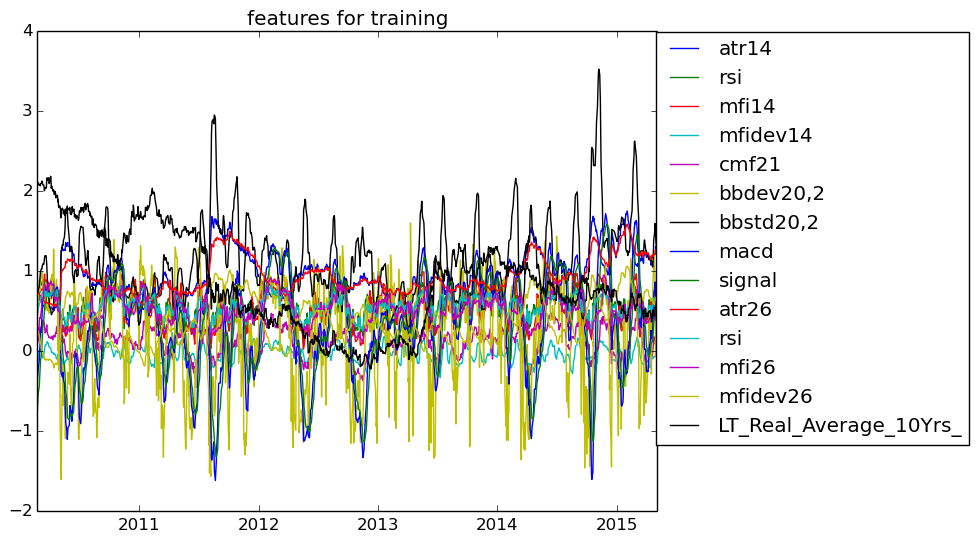

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [296]:
ignore=5;
plot(oldfeatures.timestamp,oldfeatures.values[:,1:closeidx-ignore])
legend(oldfeatures.colnames[1:closeidx-ignore],bbox_to_anchor=(1.52, 1.02))
title("features for training")

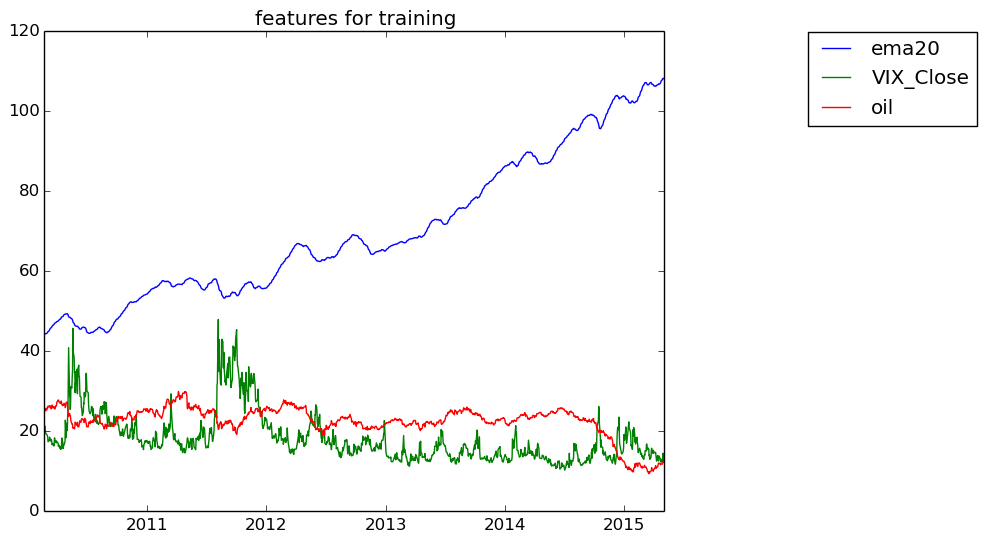

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [297]:
plot(oldfeatures.timestamp,oldfeatures.values[:,closeidx-ignore+1:closeidx-2])
legend(oldfeatures.colnames[closeidx-ignore+1:closeidx-2],bbox_to_anchor=(1.52, 1.02))
title("features for training")

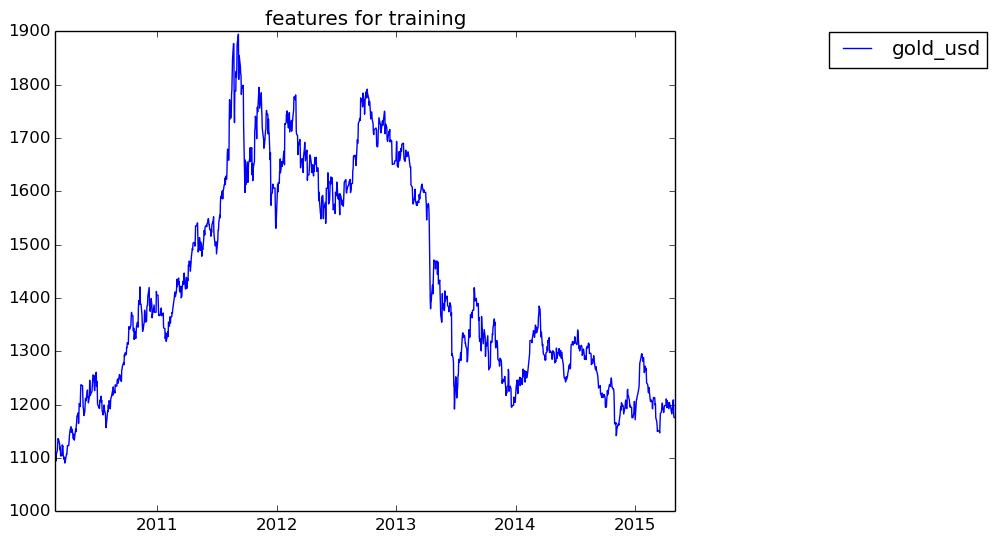

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [298]:
plot(oldfeatures.timestamp,oldfeatures.values[:,closeidx-1])
legend([oldfeatures.colnames[closeidx-1]],bbox_to_anchor=(1.52, 1.02))
title("features for training")

In [299]:
using DecisionTree
using ScikitLearn

In [300]:
ntrees=100
pricerangeidx=closeidx+3
features=oldfeatures.values[:,1:closeidx]
labels=convert(Array{Float64,1},oldfeatures.values[:,pricerangeidx])
model = build_forest(labels,features, 2, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 307.13
Avg Depth:  22.07

In [301]:
newlabels=apply_forest(model, newfeatures.values);

In [302]:
initvalue=oldfeatures.values[1,closeidx]

44.740002

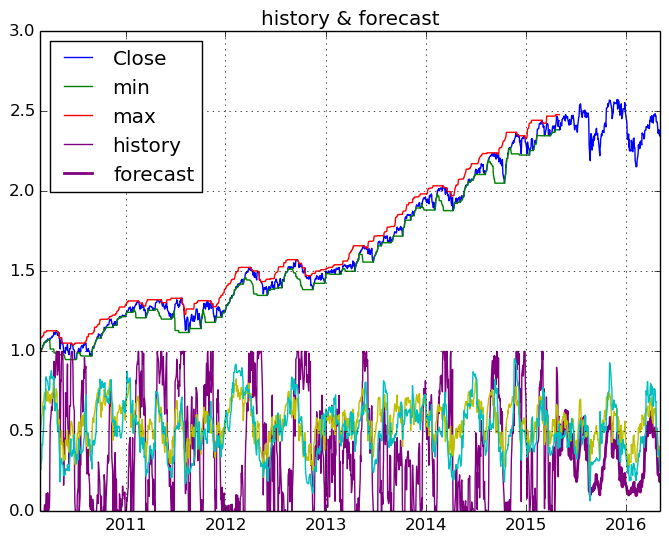

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [303]:
plot(oldfeatures.timestamp,oldfeatures.values[:,closeidx:pricerangeidx-1]./initvalue)
plot(oldfeatures.timestamp,labels,c="Purple")
plot(newfeatures.timestamp,newlabels,c="Purple",linewidth=2)
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot([oldfeatures.timestamp;newfeatures.timestamp],[oldfeatures.values[:,rsi26idx];newfeatures.values[:,rsi26idx]],c="y")
plot([oldfeatures.timestamp;newfeatures.timestamp],[oldfeatures.values[:,mfi26idx];newfeatures.values[:,mfi26idx]],c="c")
title("history & forecast")
grid("on")
legend([oldfeatures.colnames[closeidx:pricerangeidx-1];["history","forecast"]],loc="upper left")

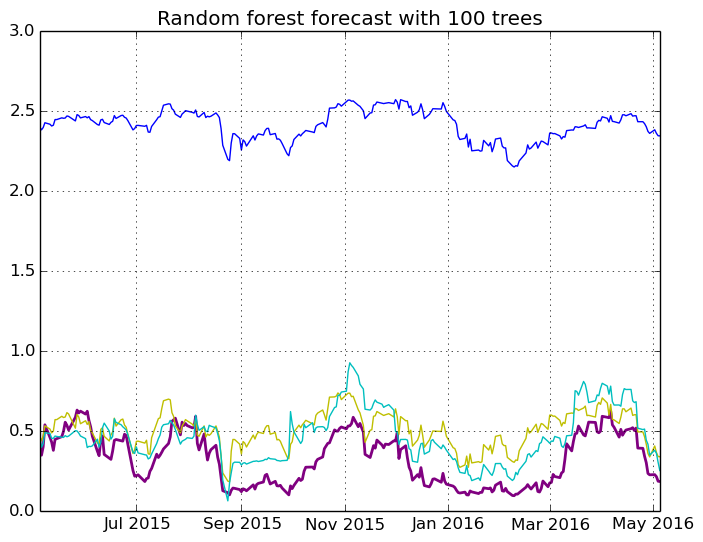

In [304]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot(newfeatures.timestamp,newlabels,c="Purple",linewidth=2)
plot(newfeatures.timestamp,newfeatures.values[:,rsi26idx],c="y")
plot(newfeatures.timestamp,newfeatures.values[:,mfi26idx],c="c")
title("Random forest forecast with "*string(ntrees)*" trees")
grid("on")
# color names http://astropython.blogspot.ie/2012/02/additional-color-names-for-matplotlib.html